In [2]:
from addit.ncf import Xncf
import jax.numpy as jnp
import numpy as np
from jax.lax import scan
from jax import jit, vmap
from addit.ncf import inc3D

In [130]:
N=10
Ng_nu=2000
Ng_beta=5
Ng_gammaL=4

nus=np.linspace(1900.0,2300.0,Ng_nu) #nu grid
beta_grid=np.logspace(-2,1,Ng_beta) #beta grid
gammaL_grid=np.logspace(-2,1,Ng_gammaL)#gammaL grid
S=np.logspace(0.0,2.0,N)
S[0:10]=1000.0

nu_lines=np.linspace(1950.0,2250.0,N)
beta=np.random.rand(N)*0.1
gammaL=np.random.rand(N)*0.01

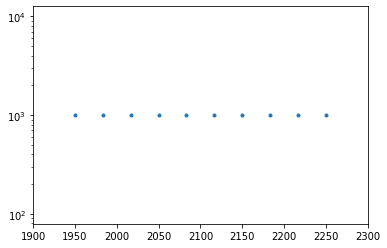

In [131]:
import matplotlib.pyplot as plt
plt.plot(nu_lines,S,".")
plt.xlim(nus[0],nus[-1])
plt.yscale("log")
plt.show()

In [132]:
def voigt_kernel(k, beta,gammaL):
    """Fourier Kernel of the Voigt Profile
    
    Args:
        k: conjugated of wavenumber
        beta: Gaussian standard deviation
        gammaL: Lorentian Half Width
        
    Returns:
        kernel (N_x,N_beta,N_gammaL)
    
    Note:
        Conversions to the (full) width, wG and wL are as follows: 
        wG=2*sqrt(2*ln2) beta
        wL=2*gamma
    
    """
    val=(jnp.pi*beta[None,:,None]*k[:,None,None])**2 + jnp.pi*gammaL[None,None,:]*k[:,None,None]
    return jnp.exp(-2.0*val)
    

In [155]:
def rundit(S,nu_lines,beta,gammaL,nu_grid,beta_grid,gammaL_grid):
    """run DIT
    
    """
    Ng_nu=len(nu_grid)
    Ng_beta=len(beta_grid)
    Ng_gammaL=len(gammaL_grid)
    
    log_beta=jnp.log(beta)
    log_gammaL=jnp.log(gammaL)
    
    log_beta_grid = jnp.log(beta_grid)
    log_gammaL_grid = jnp.log(gammaL_grid)
    
    dnu = (nu_grid[-1]-nu_grid[0])/(Ng_nu-1)
    k = jnp.fft.rfftfreq(2*Ng_nu,dnu)
    val=inc3D(S,nu_lines,log_beta,log_gammaL,nu_grid,log_beta_grid,log_gammaL_grid)
    valbuf=jnp.vstack([val,jnp.zeros_like(val)])
    fftval = jnp.fft.rfft(valbuf,axis=0)
    vk=voigt_kernel(k, beta_grid,gammaL_grid)
    fftvalsum = jnp.sum(fftval*vk,axis=(1,2))
    F0=jnp.fft.irfft(fftvalsum)[:Ng_nu]/dnu
    return F0

In [133]:
from jax.lax import scan
def folded_voigt_kernel(k,beta,gammaL,Nfold,dnu):
    """Folded Fourier Kernel of the Voigt Profile
    
    Args:
        k: conjugate wavenumber
        beta: Gaussian standard deviation
        gammaL: Lorentian Half Width
        Nfold: Folding number
        dnu: linear waveunmber grid size
        
    Returns:
        kernel (N_x,N_beta,N_gammaL)
    
    Note:
        Conversions to the (full) width, wG and wL are as follows: 
        wG=2*sqrt(2*ln2) beta
        wL=2*gamma
    
    """

    def ffold(val,dL):
        val=val+jnp.exp(-2.0*((jnp.pi*beta[None,:,None]*(k[:,None,None]+dL))**2 \
                              + jnp.pi*gammaL[None,None,:]*(k[:,None,None]+dL)))
        val=val+jnp.exp(-2.0*((jnp.pi*beta[None,:,None]*(k[:,None,None]-dL))**2 \
                              + jnp.pi*gammaL[None,None,:]*(dL-k[:,None,None])))
        null=0.0
        return val, null
    
    print(jnp.max(k),1.0/dnu)
    val=jnp.exp(-2.0*((jnp.pi*beta[None,:,None]*k[:,None,None])**2 + jnp.pi*gammaL[None,None,:]*k[:,None,None]))
    dLarray=jnp.linspace(1,Nfold,Nfold)/dnu
    
    val,nullstack=scan(ffold, val, dLarray)
    
    return val
    

In [134]:
jnp.linspace(1,4,4)

DeviceArray([1., 2., 3., 4.], dtype=float32)

In [154]:
def runditfold(S,nu_lines,beta,gammaL,nu_grid,beta_grid,gammaL_grid,Nfold):
    """run DIT folded voigt
    
    """
    Ng_nu=len(nu_grid)
    Ng_beta=len(beta_grid)
    Ng_gammaL=len(gammaL_grid)
    
    log_beta=jnp.log(beta)
    log_gammaL=jnp.log(gammaL)
    
    log_beta_grid = jnp.log(beta_grid)
    log_gammaL_grid = jnp.log(gammaL_grid)
    
    dnu = (nu_grid[-1]-nu_grid[0])/(Ng_nu-1)
    k = jnp.fft.rfftfreq(2*Ng_nu,dnu)
    val=inc3D(S,nu_lines,log_beta,log_gammaL,nu_grid,log_beta_grid,log_gammaL_grid)
    valbuf=jnp.vstack([val,jnp.zeros_like(val)])
    fftval = jnp.fft.rfft(valbuf,axis=0)
    vk=folded_voigt_kernel(k, beta_grid,gammaL_grid, Nfold, dnu)
    fftvalsum = jnp.sum(fftval*vk,axis=(1,2))
    F0=jnp.fft.irfft(fftvalsum)[:Ng_nu]/dnu
    return F0

In [160]:
def f1_voigt_kernel(k,beta,gammaL,dnu):
    """Folded Fourier Kernel of the Voigt Profile for Nfold=1 (not using scan)
    
    Args:
        k: conjugate wavenumber
        beta: Gaussian standard deviation
        gammaL: Lorentian Half Width
        dnu: linear waveunmber grid size
        
    Returns:
        kernel (N_x,N_beta,N_gammaL)
    
    Note:
        Conversions to the (full) width, wG and wL are as follows: 
        wG=2*sqrt(2*ln2) beta
        wL=2*gamma
    
    """
    
    dL=1.0/dnu
    val=jnp.exp(-2.0*((jnp.pi*beta[None,:,None]*k[:,None,None])**2 + jnp.pi*gammaL[None,None,:]*k[:,None,None]))
    val=val+jnp.exp(-2.0*((jnp.pi*beta[None,:,None]*(k[:,None,None]+dL))**2 \
                              + jnp.pi*gammaL[None,None,:]*(k[:,None,None]+dL)))
    val=val+jnp.exp(-2.0*((jnp.pi*beta[None,:,None]*(k[:,None,None]-dL))**2 \
                              + jnp.pi*gammaL[None,None,:]*(dL-k[:,None,None])))   
    
    return val
    

In [161]:
def runditf1(S,nu_lines,beta,gammaL,nu_grid,beta_grid,gammaL_grid):
    """run DIT folded voigt but Nfold=1 (not using scan)
    
    """
    Ng_nu=len(nu_grid)
    Ng_beta=len(beta_grid)
    Ng_gammaL=len(gammaL_grid)
    
    log_beta=jnp.log(beta)
    log_gammaL=jnp.log(gammaL)
    
    log_beta_grid = jnp.log(beta_grid)
    log_gammaL_grid = jnp.log(gammaL_grid)
    
    dnu = (nu_grid[-1]-nu_grid[0])/(Ng_nu-1)
    k = jnp.fft.rfftfreq(2*Ng_nu,dnu)
    val=inc3D(S,nu_lines,log_beta,log_gammaL,nu_grid,log_beta_grid,log_gammaL_grid)
    valbuf=jnp.vstack([val,jnp.zeros_like(val)])
    fftval = jnp.fft.rfft(valbuf,axis=0)
    vk=f1_voigt_kernel(k, beta_grid,gammaL_grid,dnu)
    fftvalsum = jnp.sum(fftval*vk,axis=(1,2))
    F0=jnp.fft.irfft(fftvalsum)[:Ng_nu]/dnu
    return F0

In [162]:
F0=rundit(S,nu_lines,beta,gammaL,nus,beta_grid,gammaL_grid)
F0f=runditfold(S,nu_lines,beta,gammaL,nus,beta_grid,gammaL_grid,1)
F0f1=runditf1(S,nu_lines,beta,gammaL,nus,beta_grid,gammaL_grid)

2.4987502 4.9975000000000005


In [163]:
F0f-F0f1

DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [138]:
print(len(F0[F0<0.0]))
#print(jnp.min(F0[F0<0.0]),jnp.median(F0[F0<0.0]))

0


Text(0, 0.5, '- F0')

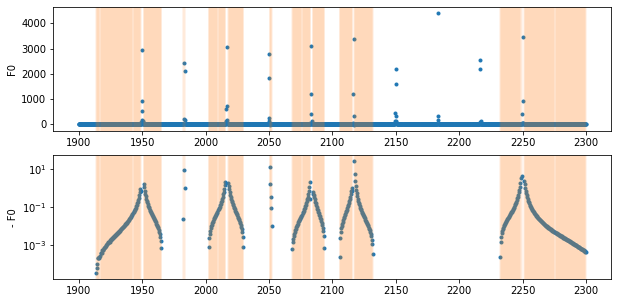

In [152]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(211)
plt.plot(nus,F0,".")
for i in nus[F0<0]:
    plt.axvline(i,alpha=0.1,color="C1")
plt.ylabel("F0")

ax=fig.add_subplot(212)
plt.plot(nus,-F0,".")
for i in nus[F0<0]:
    plt.axvline(i,alpha=0.1,color="C1")
plt.yscale("log")
plt.ylabel("- F0")
#plt.xlim(2047,2052)

/home/kawahara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  del sys.path[0]


Text(0, 0.5, '- F0f')

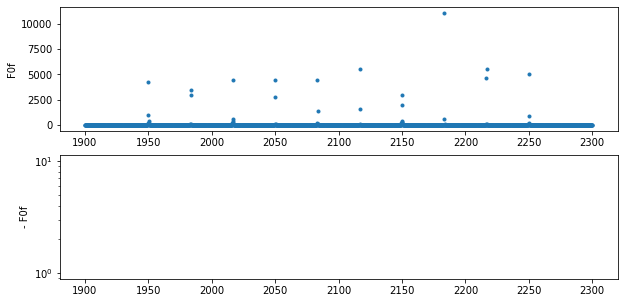

In [153]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(211)
plt.plot(nus,F0f,".")
for i in nus[F0f<0]:
    plt.axvline(i,alpha=0.1,color="C1")
plt.ylabel("F0f")

ax=fig.add_subplot(212)
plt.plot(nus,-F0f,".")
for i in nus[F0f<0]:
    plt.axvline(i,alpha=0.1,color="C1")
plt.yscale("log")
plt.ylabel("- F0f")
#plt.xlim(2047,2052)

In [140]:
F0x=rundit(S,nu_lines,beta,gammaL,nus,beta_grid,gammaL_grid)

2.4987502 4.9975000000000005


In [85]:
val=inc3D(S,nu_lines,beta,gammaL,nus,beta_grid,gammaL_grid)
valbuf=jnp.vstack([val,jnp.zeros_like(val)])
print(jnp.shape(val),jnp.shape(valbuf))

(2000, 5, 4) (4000, 5, 4)


In [28]:
def check_norm(nu_grid,beta,gammaL):
    Ng_nu=len(nu_grid)
    dnu = (nu_grid[-1]-nu_grid[0])/(Ng_nu-1)
    k = jnp.fft.rfftfreq(2*Ng_nu,dnu)
    val=(jnp.pi*beta[None,:,None]*k[:,None,None])**2 + jnp.pi*gammaL[None,None,:]*k[:,None,None]
    return jnp.mean(val),jnp.min(val),jnp.max(val)

In [29]:
check_norm(nus, beta_grid,gammaL_grid)

(DeviceArray(170076.8, dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(2468848.5, dtype=float32))

In [23]:
jnp.sum(F0)/jnp.sum(F0x)

DeviceArray(0.990519, dtype=float32)

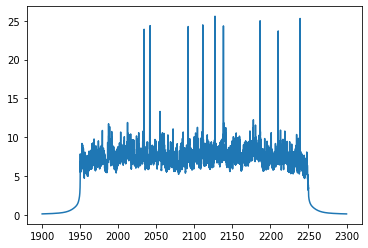

In [32]:
import matplotlib.pyplot as plt
#.plot(nus,F0x[:Ng_nu])
plt.plot(nus,F0)
#plt.yscale("log")
#plt.xlim(1960,1970)
plt.show()